In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score,f1_score, roc_curve, roc_auc_score, matthews_corrcoef
import time
import cv2
import copy
from tqdm.auto import tqdm
import seaborn as sns
import torch_directml

In [2]:
dml = torch_directml.device()
# dml = "cpu"

In [3]:
transform = transforms.Compose([
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor(),
    ])

In [4]:
dataset_path = '../splitted'
test_dataset = dsets.ImageFolder(root=f'{dataset_path}/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, drop_last=True, shuffle=False)

In [5]:
def densenet_model():
    model = torchvision.models.densenet121(weights="IMAGENET1K_V1")
    
    model.classifier = nn.Linear(1024, 2)

    return model.to(dml)

densenet = densenet_model()

densenet_model_path = "../trained-models/densenet-121.pt"

if torch.cuda.is_available():
    densenet.load_state_dict(torch.load(densenet_model_path))
else:
    densenet.load_state_dict(torch.load(densenet_model_path, map_location=torch.device('cpu'))) 

In [6]:
def resnet_model():
    model = torchvision.models.resnet152(weights='ResNet152_Weights.DEFAULT')
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, 2)

    return model.to(dml)

resnet = resnet_model()

resnet_model_path = "../trained-models/resnet-152.pt"

if torch.cuda.is_available():
    resnet.load_state_dict(torch.load(resnet_model_path))
else:
    resnet.load_state_dict(torch.load(resnet_model_path, map_location=torch.device('cpu')))

In [7]:
class MyCNN1(nn.Module):
    def __init__(self):
        super(MyCNN1, self).__init__()
        self.cnn_layer_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1, padding=0, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.cnn_layer_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=0, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.cnn_layer_3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=0, bias=False)
        self.batch_norm_3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.cnn_layer_4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding=0, bias=False)
        self.batch_norm_4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)


        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear_layer_1 = nn.Linear(512*11*11, 512)
        self.linear_layer_2 = nn.Linear(512, 256)
        self.linear_layer_3 = nn.Linear(256, 2)
                                        
    
    def forward(self, x):
        x = self.cnn_layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        x = self.maxpool_1(x)


        x = self.cnn_layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.maxpool_2(x)

        x = self.cnn_layer_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.maxpool_3(x)
        
        x = self.cnn_layer_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        

        x = self.flatten(x)

        x = self.linear_layer_1(x)
        x = self.relu(x)
        
        x = self.linear_layer_2(x)
        x = self.relu(x)
        
        x = self.linear_layer_3(x)
        
        return x
    

mycnn = MyCNN1()
mycnn.to(dml)

mycnn_model_path = "../trained-models/mycnn_three_channels.pt"

if torch.cuda.is_available():
    resnet.load_state_dict(torch.load(resnet_model_path))
else:
    resnet.load_state_dict(torch.load(resnet_model_path, map_location=torch.device('cpu')))

In [8]:
def get_predictions():
    softmax = nn.Softmax(dim=1)

    resnet.eval()
    densenet.eval()
    mycnn.eval()

    predictions = []
    real_values = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):


            images = images.to(dml)
            labels = labels.to(dml)
            
            output_resnet = softmax(resnet(images))
            output_densenet = softmax(densenet(images))
            output_mycnn = softmax(mycnn(images))
            

            probas_resnet, preds_resnet = torch.max(output_resnet, dim = 1)
            probas_densenet, preds_densenet = torch.max(output_densenet, dim = 1)
            probas_mycnn, preds_mycnn = torch.max(output_mycnn, dim = 1)

             
            for idx, preds in enumerate(zip(preds_resnet, preds_densenet, preds_mycnn)):
               if preds[0] == preds[1]:
                  predictions.append(preds[0].cpu())
               elif preds[0] == preds[2]:
                  predictions.append(preds[0].cpu()) 
               elif preds[1] == preds[2]:
                  predictions.append(preds[1].cpu())
               else:
                  if probas_resnet[idx] >= probas_mycnn[idx] and probas_resnet[idx] >= probas_densenet[idx]:
                     predictions.append(preds[0].cpu())
                  elif probas_densenet[idx] >= probas_mycnn[idx] and probas_densenet[idx] >= probas_resnet[idx]:
                     predictions.append(preds[1].cpu())
                  else:
                     predictions.append(preds[2].cpu())

            labels = labels.cpu()
            real_values.extend(labels)
            
            
    return predictions, real_values

In [9]:
pred, real = get_predictions()

  0%|          | 0/1231 [00:00<?, ?it/s]

In [10]:
print(classification_report([y_actual.item() for y_actual in real], [y_pred.item() for y_pred in pred], digits=6))

              precision    recall  f1-score   support

           0   0.958122  0.956760  0.957440      4926
           1   0.956786  0.958147  0.957466      4922

    accuracy                       0.957453      9848
   macro avg   0.957454  0.957454  0.957453      9848
weighted avg   0.957454  0.957453  0.957453      9848



Accuracy: 95.74535716990162%
Precision: 95.74539679138006%
Recall: 95.74535716990162%
F1-score: 95.74532860598023%
MCC-score: 91.49075396127311%




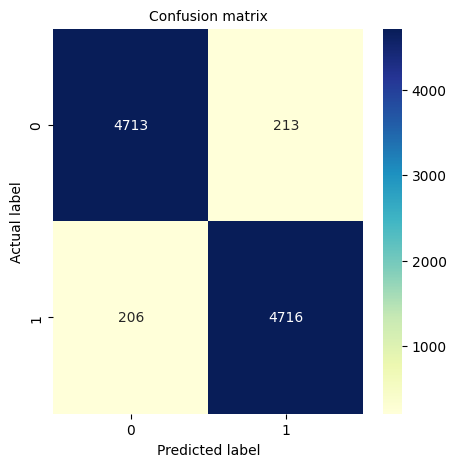

In [12]:
def score_in_details():
  y_pred = [y.item() for y in pred]
  y_real = [y.item() for y in real]
    

  accuracy = recall_score(y_real, y_pred, average='macro')
  precision = precision_score(y_real, y_pred, average='macro')
  recall = recall_score(y_real, y_pred, average='macro')
  f1 = f1_score(y_real, y_pred, average='macro')
  mcc_score = matthews_corrcoef(y_real, y_pred)

  print(f"Accuracy: {accuracy * 100}%")
  print(f"Precision: {precision * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1-score: {f1 * 100}%")
  print(f"MCC-score: {mcc_score * 100}%")
  
  print()
  print()

  class_name = [0, 1]
  conf_matrix = confusion_matrix(y_real, y_pred)
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g', xticklabels=class_name, yticklabels=class_name)
  plt.title('Confusion matrix', fontsize=10)
  plt.ylabel('Actual label', fontsize=10)
  plt.xlabel('Predicted label', fontsize=10)
  plt.show()


score_in_details()